In [ ]:
%pip install diffusers transformers xformers accelerate
%pip install opencv-contrib-python
%pip install controlnet_aux

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers.utils import load_image
from PIL import Image

image_file = "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"original_image = load_image(image_file)

def get_canny_image(original_image, low_threshold=100, high_threshold=200):
  image = np.array(original_image)

  image = cv2.Canny(image, low_threshold, high_threshold)
  image = image[:, :, None]
  image = np.concatenate([image, image, image], axis=2)
  canny_image = Image.fromarray(image)
  return canny_image

canny_image = get_canny_image(original_image)

def display_images(image1, image2):
  # Combine the images horizontally
  combined_image = Image.new('RGB', (image1.width + image2.width, max(image1.height, image2.height)))
  combined_image.paste(image1, (0, 0))
  combined_image.paste(image2, (image1.width, 0))
  # Display the combined image
  plt.imshow(combined_image)
  plt.axis('off')
  plt.show()

display_images(original_image, canny_image)



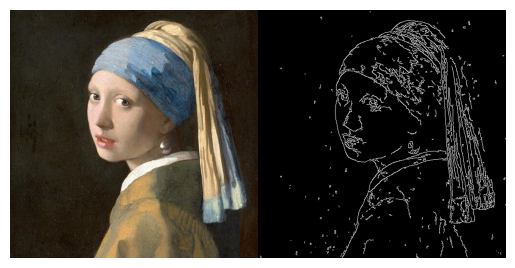